In [3]:
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from wordcloud import WordCloud

# Preprocessing and evaluation
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
import warnings 
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('reviews.csv')

In [6]:
df.head()

,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN


In [7]:
df.tail()

,Time_submitted,Review,Rating,Total_thumbsup,Reply
61589,2022-01-01 03:01:29,Even though it was communicated that lyrics fe...,1,6,NaN
61590,2022-01-01 02:13:40,"Use to be sooo good back when I had it, and wh...",1,0,NaN
61591,2022-01-01 01:02:29,This app would be good if not for it taking ov...,2,10,NaN
61592,2022-01-01 00:49:23,The app is good hard to navigate and won't jus...,2,1,NaN
61593,2022-01-01 00:19:09,Its good but sometimes it doesnt load the musi...,4,0,NaN


In [8]:
df.duplicated().sum()

0

In [9]:
df.isnull().sum()

Time_submitted        0
Review                0
Rating                0
Total_thumbsup        0
Reply             61378
dtype: int64

In [10]:
df.shape

(61594, 5)

In [11]:
df.columns

Index(['Time_submitted', 'Review', 'Rating', 'Total_thumbsup', 'Reply'], dtype='object')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61594 entries, 0 to 61593
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Time_submitted  61594 non-null  object
 1   Review          61594 non-null  object
 2   Rating          61594 non-null  int64 
 3   Total_thumbsup  61594 non-null  int64 
 4   Reply           216 non-null    object
dtypes: int64(2), object(3)
memory usage: 2.3+ MB


In [13]:
df.describe()

,Rating,Total_thumbsup
count,61594.000000,61594.000000
mean,3.155989,7.649381
std,1.673285,89.323143
min,1.000000,0.000000
25%,1.000000,0.000000
50%,3.000000,0.000000
75%,5.000000,1.000000
max,5.000000,8195.000000


In [14]:
df.nunique()

Time_submitted    61300
Review            61356
Rating                5
Total_thumbsup      532
Reply               180
dtype: int64

In [15]:
#set color for data visualization
sns.set(rc={"axes.facecolor":"#e6ffed","figure.facecolor":"#e6ffed", "grid.color":"#99e2b4",
            "axes.edgecolor":"#99e2b4", "axes.labelcolor":"#195e2d", "xtick.color":"#195e2d",
            "ytick.color":"#195e2d"})

# ['#4a7c59', '#68b0ab', '#8fc0a9', '#c8d5b9', '#faf3dd']
palettes = ['#eee82c', '#91cb3e', '#53a548', '#4c934c', '#19381f']
cmap = colors.ListedColormap(['#137547', '#2a9134', '#3fa34d', '#5bba6f', '#19381f'])

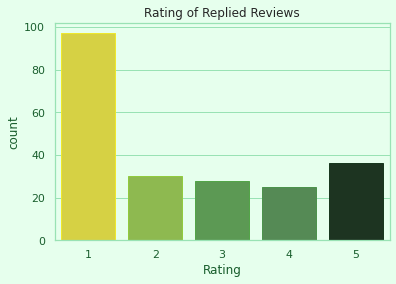

In [16]:
reply = df[~df['Reply'].isna()]
plt.figure(figsize=(15,7))
ax = sns.countplot(reply['Rating'], palette=palettes, edgecolor=palettes)
ax.set_title('Rating of Replied Reviews')
plt.show()

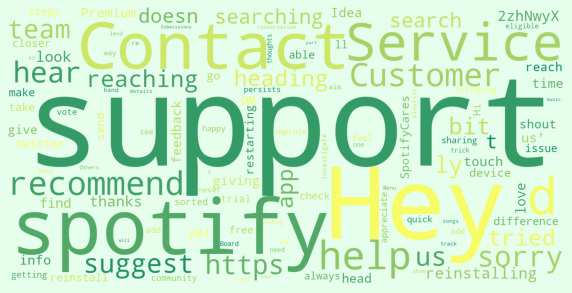

In [17]:
plt.figure(figsize=(10,10))
wc = WordCloud(max_words=1000, min_font_size=10, height=600, width=1200, collocations=False,
               background_color='#e6ffed', colormap='summer').generate(' '.join(reply['Reply']))

plt.axis('off')
plt.imshow(wc)
plt.show()

In [18]:
def top_words(text):
    word = pd.DataFrame(wc.process_text(''.join(text)).items()).sort_values(1, ascending=False)
    
    print('Top 5 words that appear most frequently:\n')
    for i in range(5):
        item = word.iloc[i]
        print(item[0] + '\t--> ' + str(item[1]))

In [19]:
top_words(reply['Reply'])

Top 5 words that appear most frequently:

support	--> 204
Hey	--> 194
spotify	--> 166
Contact	--> 118
Service	--> 115


In [20]:
df['Time_submitted'] = pd.to_datetime(df['Time_submitted'])

df['Date'] = df['Time_submitted'].apply(lambda x: x.date())

reviews_per_day = df.groupby(df['Date']).count()['Review']
reviews_per_day = reviews_per_day.reset_index()
reviews_per_day['Month'] = reviews_per_day['Date'].apply(lambda x: x.month)

In [21]:
reviews_per_day.rename(columns={'Review':'Total_review'}, inplace=True)
reviews_per_day.head()

,Date,Total_review,Month
0,2022-01-01,46,1
1,2022-01-02,43,1
2,2022-01-03,66,1
3,2022-01-04,56,1
4,2022-01-05,64,1


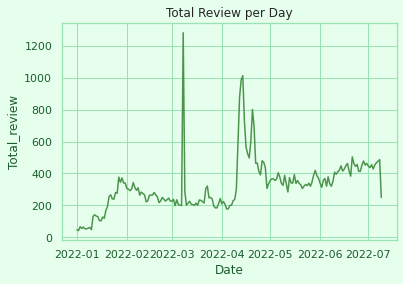

In [22]:
ax = sns.lineplot(data=reviews_per_day, x='Date', y='Total_review', color='#4c934c')
ax.set_title('Total Review per Day')
plt.show()

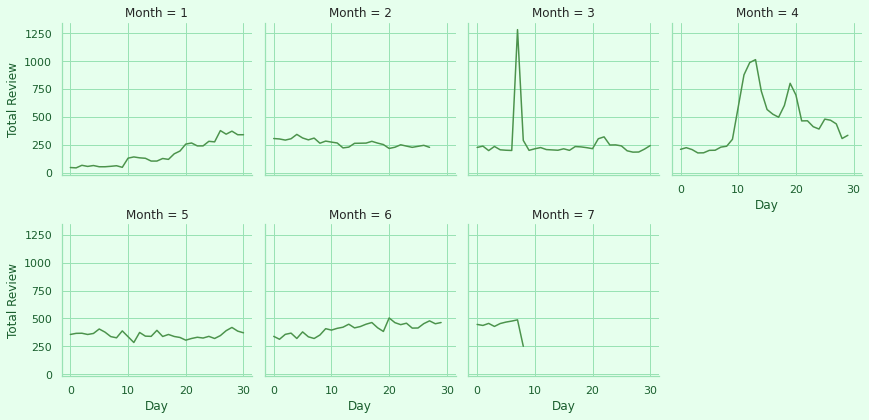

In [23]:
g = sns.FacetGrid(data=reviews_per_day, col='Month', col_wrap=4)
g.map(plt.plot, 'Total_review', color='#4c934c')
g.set_axis_labels(x_var='Day', y_var='Total Review')
plt.show()

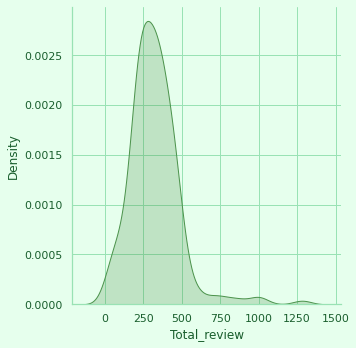

In [24]:
ax = sns.displot(data=reviews_per_day, x='Total_review', kind='kde', fill=True, color='#4c934c')
plt.show()

In [25]:
# Let's change the rating to be more general and easier to understand
def rating(score):
    if score > 3:
        return 'Good'
    elif score == 3:
        return 'Netral'
    else:
        return 'Bad'

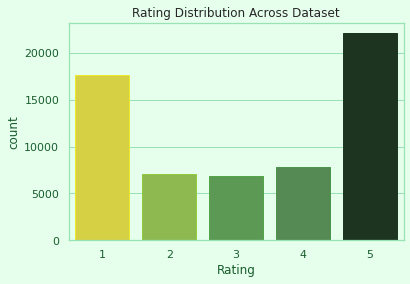

In [26]:
ax = sns.countplot(data=df, x='Rating', palette=palettes, edgecolor=palettes)
ax.set_title('Rating Distribution Across Dataset')
plt.show()

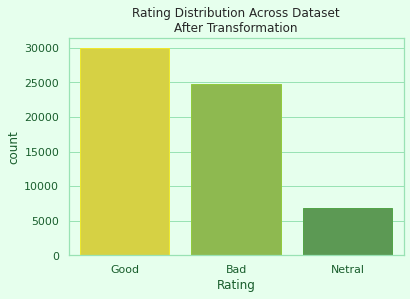

In [27]:
df['Rating'] = df['Rating'].apply(rating)
ax = sns.countplot(data=df, x='Rating', palette=palettes, edgecolor=palettes)
ax.set_title('Rating Distribution Across Dataset\nAfter Transformation')
plt.show()

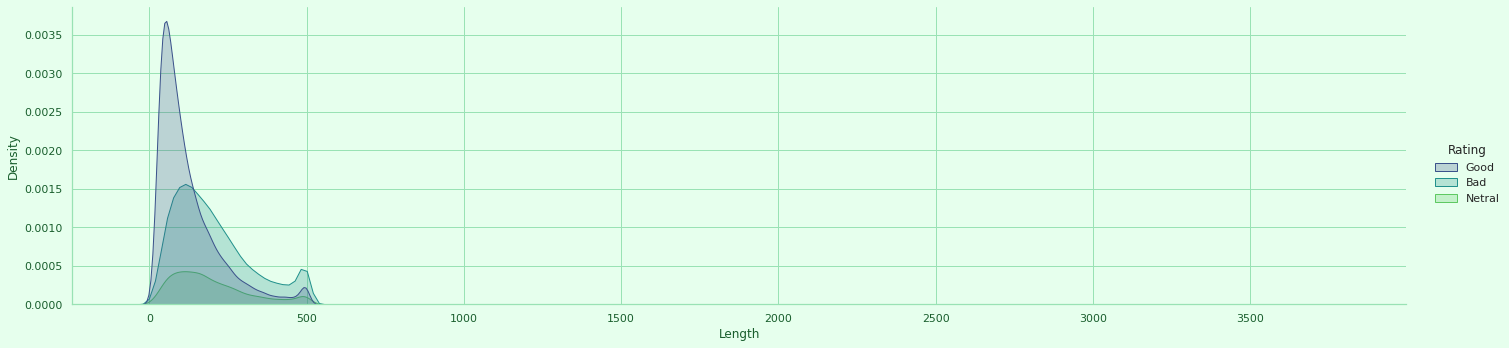

In [28]:
df['Length'] = df['Review'].apply(len)
ax = sns.displot(data=df, x='Length', hue='Rating', kind='kde', fill=True, aspect=4, palette='viridis')
plt.show()

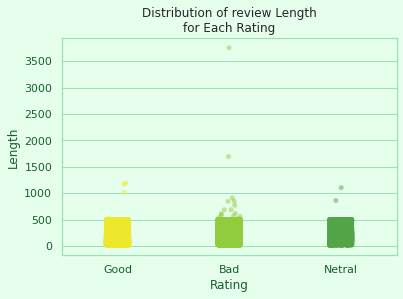

In [29]:
ax = sns.stripplot(data=df, x='Rating', y='Length', alpha=0.5, palette=palettes, edgecolor=palettes)
ax.set_title('Distribution of review Length\nfor Each Rating')
plt.show()

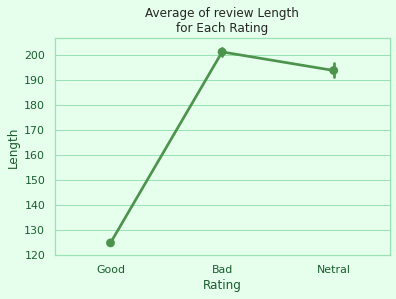

In [30]:
ax = sns.pointplot(data=df, x='Rating', y='Length', color='#4c934c')
ax.set_title('Average of review Length\nfor Each Rating')
plt.show()

In [31]:
max_thumb = df['Total_thumbsup'].max()
print(df[df['Total_thumbsup'] == max_thumb].iloc[0]['Review'])

The app is very good. I got to explore many new songs. However, I took out a star because of a few reasons. First:- It sometimes lags and won't show the music dialog box on your screen or in the app and for this I have to restart it. Second:- I cannot delete my history on phone. Third:- I cannot shuffle playlists or Albums. They have to play on the fixed sequence. Fourth:- I cannot see which song is going to play next if it's a radio and Fifth:- Sometimes the song stops and doesn't start radio


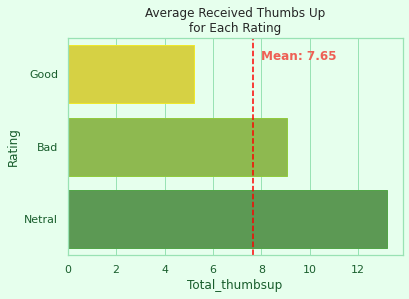

In [32]:
mean_thumb = df['Total_thumbsup'].mean()

ax = sns.barplot(data=df, y='Rating', x='Total_thumbsup', orient='h', ci=None, palette=palettes, edgecolor=palettes)
ax.set_title('Average Received Thumbs Up\nfor Each Rating')
plt.axvline(mean_thumb, color='red', ls='--')
plt.text(x=8, y=-0.2, s='Mean: ' + str(round(mean_thumb, 2)), color='#ee6055', weight='bold')
plt.show()

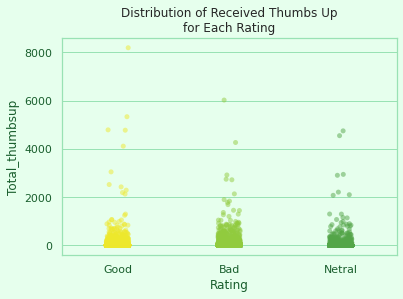

In [33]:
ax = sns.stripplot(data=df, x='Rating', y='Total_thumbsup', palette=palettes, edgecolor=palettes, alpha=0.5)
ax.set_title('Distribution of Received Thumbs Up\nfor Each Rating')
plt.show()

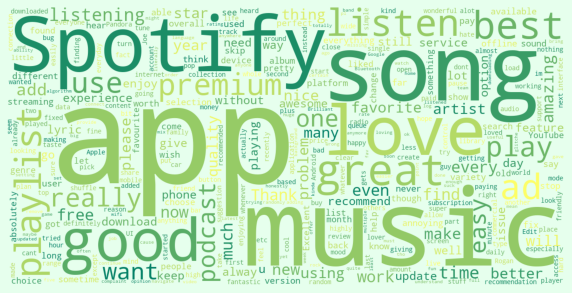

In [34]:
# Most popular word for good review
good = df[df['Rating'] == 'Good']['Review']

plt.figure(figsize=(10,10))
wc = WordCloud(max_words=1000, min_font_size=10, height=600, width=1200, collocations=False,
               background_color='#e6ffed', colormap='summer').generate(' '.join(good))

plt.axis('off')
plt.imshow(wc)
plt.show()

In [35]:
top_words(good)

Top 5 words that appear most frequently:

app	--> 15681
music	--> 14881
song	--> 10608
Spotify	--> 8621
love	--> 6909


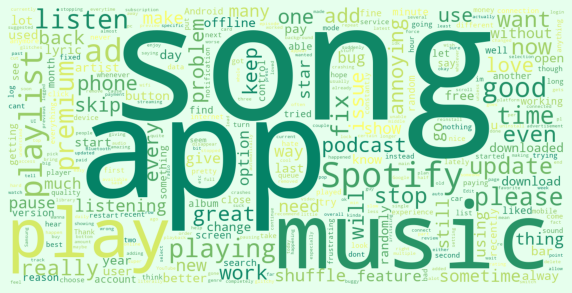

In [36]:
# Most popular word for netral review
netral = df[df['Rating'] == 'Netral']['Review']

plt.figure(figsize=(10,10))
wc = WordCloud(max_words=1000, min_font_size=10, height=600, width=1200, collocations=False,
               background_color='#e6ffed', colormap='summer').generate(' '.join(netral))

plt.axis('off')
plt.imshow(wc)
plt.show()

In [37]:
top_words(netral)

Top 5 words that appear most frequently:

song	--> 4993
app	--> 4125
music	--> 2322
play	--> 2032
Spotify	--> 1837


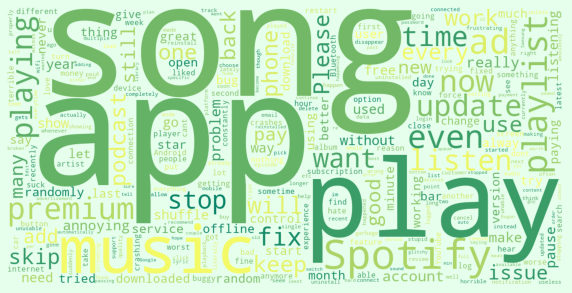

In [38]:
# Most popular word for bad review
bad = df[df['Rating'] == 'Bad']['Review']

plt.figure(figsize=(10,10))
wc = WordCloud(max_words=1000, min_font_size=10, height=600, width=1200, collocations=False,
               background_color='#e6ffed', colormap='summer').generate(' '.join(bad))

plt.axis('off')
plt.imshow(wc)
plt.show()

In [39]:
top_words(bad)

Top 5 words that appear most frequently:

song	--> 16766
app	--> 16445
play	--> 8867
music	--> 7745
Spotify	--> 7381


In [40]:
df.head()

,Time_submitted,Review,Rating,Total_thumbsup,Reply,Date,Length
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",Good,2,NaN,2022-07-09,112
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,Good,1,NaN,2022-07-09,86
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",Good,0,NaN,2022-07-09,106
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,Bad,1,NaN,2022-07-09,47
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,Bad,1,NaN,2022-07-09,100


In [41]:
df_final = df[['Review', 'Rating', 'Length']]

In [42]:
# Total word in dataset before cleaning
length = df_final['Length'].sum()

In [43]:
print('Original:')
print(df['Review'][7])
print()

sentence = []
for word in df['Review'][7].split():
    stemmer = SnowballStemmer('english')
    sentence.append(stemmer.stem(word))
print('Stemming:')
print(' '.join(sentence))
print()

sentence = []
for word in df['Review'][7].split():
    lemmatizer = WordNetLemmatizer()
    sentence.append(lemmatizer.lemmatize(word, 'v'))
print('Lemmatization:')
print(' '.join(sentence))

Original:
Still extremely slow when changing storage to external sd card.. I'm convinced this is done on purpose, spotify knows of this issue and has done NOTHING to solve it! Over time I have changed sd cards, each being faster in read, write speeds(all samsung brand). And please add "don't like song" so it will never appear again in my searches or playlists.

Stemming:
still extrem slow when chang storag to extern sd card.. i'm convinc this is done on purpose, spotifi know of this issu and has done noth to solv it! over time i have chang sd cards, each be faster in read, write speeds(al samsung brand). and pleas add "don't like song" so it will never appear again in my search or playlists.

Lemmatization:
Still extremely slow when change storage to external sd card.. I'm convince this be do on purpose, spotify know of this issue and have do NOTHING to solve it! Over time I have change sd cards, each be faster in read, write speeds(all samsung brand). And please add "don't like song" 

In [44]:
def cleaning(text):
    #remove punctuations and uppercase
    clean_text = text.translate(str.maketrans('','',string.punctuation)).lower()
    
    #remove stopwords
    clean_text = [word for word in clean_text.split() if word not in stopwords.words('english')]
    
    #lemmatize the word
    sentence = []
    for word in clean_text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word, 'v'))

    return ' '.join(sentence)

In [45]:
df['Review'] = df['Review'].apply(cleaning)

In [46]:
df['Length'] = df['Review'].apply(len)
new_length = df['Length'].sum()

print('Total word before cleaning: {}'.format(length))
print('Total word after cleaning: {}'.format(new_length))

Total word before cleaning: 10059745
Total word after cleaning: 6210516


In [47]:
X_train, X_test, y_train, y_test = train_test_split(df['Review'], df['Rating'], test_size=0.2)

<a id="7"></a>
<h1 style="font-family: Trebuchet MS; font-size: 24px; color: #5bba6f; text-align: left; line-height: 1.25;"><b>LSTM</b></h1>

Long Short-Term Memory (LSTM) networks are a type of recurrent neural network capable of learning order dependence in sequence prediction problems

<h1 style="font-family: Trebuchet MS; font-size: 16px; color: #5bba6f; text-align: left; line-height: 1.25;"><b>3 basic requirements of a recurrent neural network:</b></h1>

* That the system be able to store information for an arbitrary duration.
* That the system be resistant to noise (i.e. fluctuations of the inputs that are random or irrelevant to predicting a correct output).
* That the system parameters be trainable (in reasonable time).

In [48]:
tokenizer = Tokenizer(num_words=50000, oov_token='<OOV>')

tokenizer.fit_on_texts(X_train)
# print(tokenizer.word_index)
total_word = len(tokenizer.word_index)
print('Total distinct words: {}'.format(total_word))

train_seq = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_seq)

test_seq = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_seq)

# One hot encoding the label
lb = LabelBinarizer()
train_labels = lb.fit_transform(y_train)
test_labels = lb.transform(y_test)

Total distinct words: 25503


In [49]:
model_lstm = tf.keras.models.Sequential([tf.keras.layers.Embedding(total_word, 8),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(16, activation='relu'),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(3, activation='softmax')])

model_lstm.summary()

2022-10-29 09:26:44.519147: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-29 09:26:44.642272: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-29 09:26:44.643051: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-29 09:26:44.644740: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 8)           204024    
_________________________________________________________________
bidirectional (Bidirectional (None, 32)                3200      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 51        
Total params: 207,803
Trainable params: 207,803
Non-trainable params: 0
__________________________________________________

In [50]:
model_lstm.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model_lstm.fit(train_padded, train_labels, epochs=25, validation_data=(test_padded, test_labels))

Epoch 1/25


2022-10-29 09:26:47.855297: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-10-29 09:26:51.073924: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1540/1540 [==============================] - 42s 25ms/step - loss: 0.9862 - accuracy: 0.5001 - val_loss: 0.8725 - val_accuracy: 0.6285
Epoch 2/25
1540/1540 [==============================] - 37s 24ms/step - loss: 0.8074 - accuracy: 0.6855 - val_loss: 0.6651 - val_accuracy: 0.7458
Epoch 3/25
1540/1540 [==============================] - 37s 24ms/step - loss: 0.6908 - accuracy: 0.7551 - val_loss: 0.6262 - val_accuracy: 0.7699
Epoch 4/25
1540/1540 [==============================] - 37s 24ms/step - loss: 0.6542 - accuracy: 0.7734 - val_loss: 0.6097 - val_accuracy: 0.7764
Epoch 5/25
1540/1540 [==============================] - 37s 24ms/step - loss: 0.6335 - accuracy: 0.7838 - val_loss: 0.5999 - val_accuracy: 0.7782
Epoch 6/25
1540/1540 [==============================] - 37s 24ms/step - loss: 0.6172 - accuracy: 0.7890 - val_loss: 0.5945 - val_accuracy: 0.7795
Epoch 7/25
1540/1540 [==============================] - 37s 24ms/step - loss: 0.6055 - accuracy: 0.7916 - val_loss: 0.5944 - val_accura

<AxesSubplot:>

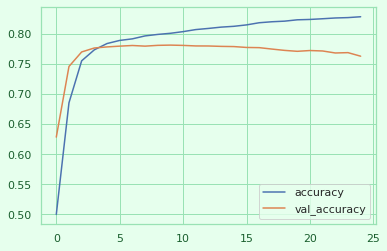

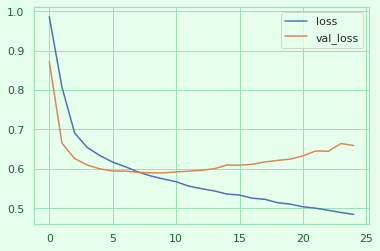

In [51]:
metrics_lstm = pd.DataFrame(model_lstm.history.history)
metrics_lstm[['accuracy', 'val_accuracy']].plot()
metrics_lstm[['loss', 'val_loss']].plot()

<a id="8"></a>
<h1 style="font-family: Trebuchet MS; font-size: 24px; color: #5bba6f; text-align: left; line-height: 1.25;"><b>GRU</b></h1>

Gated recurrent units are a gating mechanism in recurrent neural networks, introduced in 2014 by Kyunghyun Cho et al. The GRU is like a long short-term memory with a forget gate, but has fewer parameters than LSTM, as it lacks an output gate. Another Interesting thing about  GRU is that, unlike LSTM, it does not have a separate cell state (Ct). It only has a hidden state(Ht). Due to the simpler architecture, GRUs are faster to train.

In [52]:
model_gru = tf.keras.models.Sequential([tf.keras.layers.Embedding(total_word, 8),
                                    tf.keras.layers.GRU(8),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(3, activation='softmax')])

model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 8)           204024    
_________________________________________________________________
gru (GRU)                    (None, 8)                 432       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 27        
Total params: 204,483
Trainable params: 204,483
Non-trainable params: 0
_________________________________________________________________


In [53]:
model_gru.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model_gru.fit(train_padded, train_labels, epochs=25, validation_data=(test_padded, test_labels))

Epoch 1/25
1540/1540 [==============================] - 22s 13ms/step - loss: 1.0030 - accuracy: 0.4846 - val_loss: 0.9067 - val_accuracy: 0.5983
Epoch 2/25
1540/1540 [==============================] - 19s 12ms/step - loss: 0.8641 - accuracy: 0.6302 - val_loss: 0.7639 - val_accuracy: 0.7095
Epoch 3/25
1540/1540 [==============================] - 20s 13ms/step - loss: 0.7514 - accuracy: 0.7164 - val_loss: 0.6649 - val_accuracy: 0.7475
Epoch 4/25
1540/1540 [==============================] - 20s 13ms/step - loss: 0.6681 - accuracy: 0.7656 - val_loss: 0.6170 - val_accuracy: 0.7728
Epoch 5/25
1540/1540 [==============================] - 19s 12ms/step - loss: 0.6286 - accuracy: 0.7809 - val_loss: 0.6005 - val_accuracy: 0.7744
Epoch 6/25
1540/1540 [==============================] - 20s 13ms/step - loss: 0.6078 - accuracy: 0.7885 - val_loss: 0.5924 - val_accuracy: 0.7825
Epoch 7/25
1540/1540 [==============================] - 19s 12ms/step - loss: 0.5930 - accuracy: 0.7920 - val_loss: 0.5885 -

<AxesSubplot:>

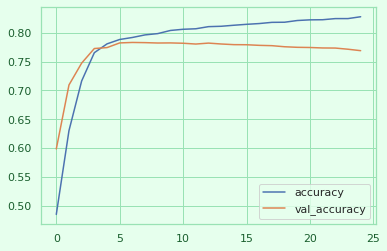

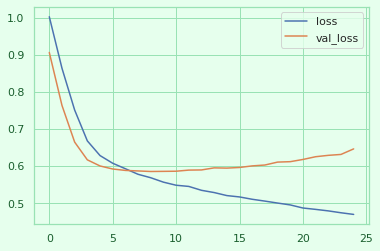

In [54]:
metrics_gru = pd.DataFrame(model_gru.history.history)
metrics_gru[['accuracy', 'val_accuracy']].plot()
metrics_gru[['loss', 'val_loss']].plot()

There are not many difference between LSTM and GRU in terms of accuracy and loss. So, in the following cell, we will build model using ELECTRA Transformer and see the overall performance

<a id="9"></a>
<h1 style="font-family: Trebuchet MS; font-size: 24px; color: #5bba6f; text-align: left; line-height: 1.25;"><b>ELECTRA</b></h1>

ELECTRA is a new pretraining approach which trains two transformer models: the generator and the discriminator. It stands for Efficiently Learning an Encoder that Classifies Token Replacements Accurately and it is a BERT-like model. The generator’s role is to replace tokens in a sequence, and is therefore trained as a masked language model. The discriminator, which is the model we’re interested in, tries to identify which tokens were replaced by the generator in the sequence

<h1 style="font-family: Trebuchet MS; font-size: 16px; color: #5bba6f; text-align: left; line-height: 1.25;"><b>Other valuable resources:</b></h1>

- [Official documentation](https://www.tensorflow.org/text/tutorials/classify_text_with_bert)
- [Codebasics channel](https://www.youtube.com/watch?v=hOCDJyZ6quA)

In [55]:
bert_preprocess_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
bert_encoder_url = 'https://tfhub.dev/google/electra_base/2'

bert_preprocess = hub.KerasLayer(bert_preprocess_url)
bert_encoder = hub.KerasLayer(bert_encoder_url)

In [56]:
# Example
def bert_example(sentence):
    preprocessed_text = bert_preprocess(sentence)
    return bert_encoder(preprocessed_text)['pooled_output']

In [57]:
exp = bert_example(['cat', 'dog', 'eye', 'nose'])

from sklearn.metrics.pairwise import cosine_similarity
print(cosine_similarity([exp[0]], [exp[1]])) # cat and dog
print(cosine_similarity([exp[0]], [exp[2]])) # cat and eye
print(cosine_similarity([exp[2]], [exp[3]])) # eye and nose

[[0.6066152]]
[[0.31586123]]
[[0.5116301]]


In [58]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessed_text = bert_preprocess(text_input)
output = bert_encoder(preprocessed_text)

# DNN
x = tf.keras.layers.Dropout(0.2)(output['pooled_output'])
x = tf.keras.layers.Dense(3, activation='softmax')(x)

# Build the model
model_bert = tf.keras.Model(text_input, x)

In [59]:
model_bert.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        {'input_word_ids': ( 0           input_1[0][0]                    
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      {'encoder_outputs':  109482241   keras_layer[0][0]                
                                                                 keras_layer[0][1]                
                                                                 keras_layer[0][2]                
______________________________________________________________________________________________

In [60]:
model_bert.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.Adam(learning_rate=0.0005),
                   metrics=['accuracy'])

model_bert.fit(X_train, train_labels, epochs=25, batch_size=32, validation_data=(X_test, test_labels))

Epoch 1/25
1540/1540 [==============================] - 423s 270ms/step - loss: 0.8254 - accuracy: 0.6512 - val_loss: 0.7672 - val_accuracy: 0.6881
Epoch 2/25
1540/1540 [==============================] - 413s 268ms/step - loss: 0.7649 - accuracy: 0.6841 - val_loss: 0.7356 - val_accuracy: 0.7061
Epoch 3/25
1540/1540 [==============================] - 413s 268ms/step - loss: 0.7497 - accuracy: 0.6935 - val_loss: 0.7307 - val_accuracy: 0.6988
Epoch 4/25
1540/1540 [==============================] - 413s 268ms/step - loss: 0.7444 - accuracy: 0.6957 - val_loss: 0.7223 - val_accuracy: 0.7057
Epoch 5/25
1540/1540 [==============================] - 413s 269ms/step - loss: 0.7415 - accuracy: 0.6960 - val_loss: 0.7178 - val_accuracy: 0.7088
Epoch 6/25
1540/1540 [==============================] - 413s 268ms/step - loss: 0.7434 - accuracy: 0.6963 - val_loss: 0.7134 - val_accuracy: 0.7178
Epoch 7/25
1540/1540 [==============================] - 412s 268ms/step - loss: 0.7400 - accuracy: 0.6987 - val_

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1540/1540 [==============================] - 413s 268ms/step - loss: 0.7362 - accuracy: 0.6991 - val_loss: 0.7102 - val_accuracy: 0.7173
Epoch 14/25
1540/1540 [==============================] - 412s 267ms/step - loss: 0.7367 - accuracy: 0.6998 - val_loss: 0.7059 - val_accuracy: 0.7181
Epoch 15/25
1540/1540 [==============================] - 412s 268ms/step - loss: 0.7367 - accuracy: 0.6994 - val_loss: 0.7056 - val_accuracy: 0.7171
Epoch 16/25
1540/1540 [==============================] - 412s 267ms/step - loss: 0.7373 - accuracy: 0.6994 - val_loss: 0.7069 - val_accuracy: 0.7153
Epoch 17/25
1540/1540 [==============================] - 412s 267ms/step - loss: 0.7369 - accuracy: 0.6975 - val_loss: 0.7157 - val_accuracy: 0.7060
Epoch 18/25
1540/1540 [==============================] - 412s 268ms/step - loss: 0.7372 - accuracy: 0.6982 - val_loss: 0.7046 - val_accuracy: 0.7167
Epoch 19/25
1540/1540 [==============================] - 412s 267ms/step - loss: 0.7370 - accuracy: 0.6992 - val_loss:

<AxesSubplot:>

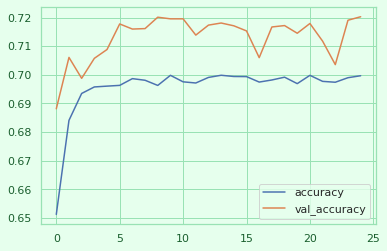

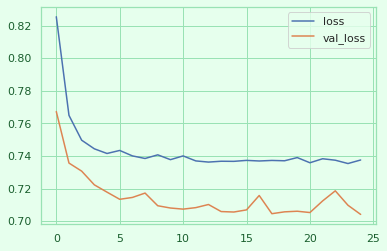

In [61]:
metrics_bert = pd.DataFrame(model_bert.history.history)
metrics_bert[['accuracy', 'val_accuracy']].plot()
metrics_bert[['loss', 'val_loss']].plot()

<a id="10"></a>
<h1><b><span style="color: #3fa34d; font-size: 28px">PREDICTION</span></b></h1>

In [67]:
def lstm_prediction(text):
    clean_text = cleaning(text)
    seq = tokenizer.texts_to_sequences([clean_text])
    padded = pad_sequences(seq)

    pred = model_lstm.predict(padded)
    # Get the label name back
    result = lb.inverse_transform(pred)[0]
    
    return result

def gru_prediction(text):
    clean_text = cleaning(text)
    seq = tokenizer.texts_to_sequences([clean_text])
    padded = pad_sequences(seq)

    pred = model_gru.predict(padded)
    # Get the label name back
    result = lb.inverse_transform(pred)[0]
    
    return result

def bert_prediction(text):
    clean_text = cleaning(text)
    
    pred = model_bert.predict([clean_text])
    # Get the label name back
    result = lb.inverse_transform(pred)[0]
    
    return result

In [63]:
text1 = "There is a major bug in the app. I can't play my playlist since the last 2 days"

print('LSTM\t: ', lstm_prediction(text1))
print('GRU\t: ', gru_prediction(text1))
print('BERT\t: ', bert_prediction(text1))

LSTM	:  Bad
GRU	:  Bad
BERT	:  Bad


In [64]:
text2 = "Love this app! the interface is clean and pleasing to the eye"

print('LSTM\t: ', lstm_prediction(text2))
print('GRU\t: ', gru_prediction(text2))
print('BERT\t: ', bert_prediction(text2))

LSTM	:  Good
GRU	:  Good
BERT	:  Good


In [65]:
text3 = "The overall experience is good, but the ads really annoying"

print('LSTM\t: ', lstm_prediction(text3))
print('GRU\t: ', gru_prediction(text3))
print('BERT\t: ', bert_prediction(text3))

LSTM	:  Good
GRU	:  Good
BERT	:  Good
